<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Foundations of Data Science <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
<font color=3C99D size=5>
    Project: Financial Analysis on Twitter <br>
<font color=696880 size=4>
    Parishad Mokhber - 98100537 <br>
    
____

## Part 3: Financial Sentiment Analysis

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tweets = pd.read_csv('tweets.csv')
entities = pd.read_csv('entities.csv')
companies = pd.read_csv('companies.csv')
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

In [61]:
# As the large number of tweets is hard to process, we only subsample 10K of them
tweets = tweets.sample(10000, random_state=42)
tweets.head()

,id,text,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_user_id,lang,source,created_at
4385281,887340519977869312,RT @UnitedHealthGrp: $UNH Wichmann: UNH genera...,27533449,0,0,887293878520483840,917104380,en,"<a href=""http://twitter.com/download/iphone"" r...",2017-07-18 15:57:20
1425403,872476805768282113,Nice shake out of weak hands yesterday MM's W...,840817404,0,0,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",2017-06-07 15:34:14
2171408,876082902244540416,RT @MOMOSTOCKTRADES: $VDRM $CNBX $OWCP $USRM $...,834749008044244992,0,0,876081585686237184,234956680,tl,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2017-06-17 14:23:35
3564549,883029194942402560,Commercial Metals Company director just picked...,2616445050,0,0,0,0,en,"<a href=""http://www.conferencecalltranscripts....",2017-07-06 18:25:40
7335060,900024884318883843,Hunting for stocks to short? Here's one w/ a l...,3254642543,0,0,0,0,en,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",2017-08-22 16:00:28


In [84]:
pd.DataFrame(tweets['text'])

,text
4385281,RT @UnitedHealthGrp: $UNH Wichmann: UNH genera...
1425403,Nice shake out of weak hands yesterday MM's W...
2171408,RT @MOMOSTOCKTRADES: $VDRM $CNBX $OWCP $USRM $...
3564549,Commercial Metals Company director just picked...
7335060,Hunting for stocks to short? Here's one w/ a l...
...,...
6207139,$ATRS - Current Report Filing (8-k) https://t....
954882,$WDR Looking for an entry for next leg up. Lon...
7966050,RT @Goonalerts: I just came through again and ...
7831741,#Travelzoo $89* -- Las Vegas Nonstop Flights f...


In [87]:
df = pd.DataFrame(tweets['text'])

def clean_data(df):
    print("Number of nulls before cleaning:")
    print(df.isnull().sum())
    df = df.dropna(subset=['text'])
    df['text'] = df['text'].str.lower()
    print("Number of nulls after cleaning:")
    print(df.isnull().sum())

    return df
df = clean_data(df)
df.head(10)

Number of nulls before cleaning:
text    0
dtype: int64
Number of nulls after cleaning:
text    0
dtype: int64


,text
4385281,rt @unitedhealthgrp: $unh wichmann: unh genera...
1425403,nice shake out of weak hands yesterday mm's w...
2171408,rt @momostocktrades: $vdrm $cnbx $owcp $usrm $...
3564549,commercial metals company director just picked...
7335060,hunting for stocks to short? here's one w/ a l...
896297,janssen to return rights to min-202 to minerva...
7459211,$alv posible señal para corto. - confirmación ...
9082825,"sept 12 tuesday, $nflx closed $185.15 and hit ..."
9019202,rt @bvz_investools: watch tonight's #marketfor...
5029083,rt @marketcurrents: energy/materials - top gai...


**Apply two best classifiers of the second part on the dataset of the first part.**

As we saw in the previous part, the fine-tuned Bert model and the Logistic Regression classifier trained on Bag of Words features had the best results, and therefore we will be using them in this part.

### Bert Classifier

In [89]:
df['labels'] = 0
df.rename(columns={'text':'tweets'}, inplace=True)
df.head()

,tweets,labels
4385281,rt @unitedhealthgrp: $unh wichmann: unh genera...,0
1425403,nice shake out of weak hands yesterday mm's w...,0
2171408,rt @momostocktrades: $vdrm $cnbx $owcp $usrm $...,0
3564549,commercial metals company director just picked...,0
7335060,hunting for stocks to short? here's one w/ a l...,0


In [90]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split


class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df_test = df

max_len = 128  # Max length of tokens
test_dataset = TweetDataset(
    tweets=df_test.tweets.to_numpy(),
    labels=df_test.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

In [91]:
from torch.utils.data import DataLoader
import tqdm
from transformers import BertForSequenceClassification

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
batch_size = 128

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=8
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('finetuned_bert.pth'))

model = model.to(device).eval()
all_tweets = []
all_preds = []

for d in tqdm.tqdm(test_loader):
    tweet_text = d["tweet_text"]
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )
    logits = outputs[1]
    _, preds = torch.max(logits, dim=1)
    
    all_tweets.append(tweet_text)
    all_preds.append(preds)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Showing some of the tweets and predictions of model

In [92]:
for i in range(20):
    print(f'Tweet: {all_tweets[0][i]} \n Predicted Sentiment: {all_preds[0][i]}')

Tweet: rt @unitedhealthgrp: $unh wichmann: unh generated strong cash flows, up 29% yoy, as adjusted net earnings grew 26% over last year’s q2 to $… 
 Predicted Sentiment: 1
Tweet: nice shake out of weak hands yesterday mm's  we're onto you mofoz$nke 
 Predicted Sentiment: 1
Tweet: rt @momostocktrades: $vdrm $cnbx $owcp $usrm $aapl $fb $goog #stocks $znga $snap $srpt $amgn $icnb $nak $pmcb $svte $frzt $lqmt $chro $gs h… 
 Predicted Sentiment: 0
Tweet: commercial metals company director just picked up 1,692 shares  https://t.co/40v0re1io2 $cmc 
 Predicted Sentiment: 1
Tweet: hunting for stocks to short? here's one w/ a low piotroski score: foundation medicine, inc. $fmi… https://t.co/vgos0tjcxm 
 Predicted Sentiment: 1
Tweet: janssen to return rights to min-202 to minerva after j&amp;j's actelion deal goes through; minerva up 14% after... https://t.co/lipayu4t76 $nerv 
 Predicted Sentiment: 1
Tweet: $alv posible señal para corto. - confirmación en $105.39 / sl: $106.18 https://t.co/crttr

As we can see, the model's overall performance seems to be satisfactory.

In [93]:
flattened_texts = [item for sublist in all_tweets for item in sublist]
flattened_sentiments = [item.cpu().numpy() for sublist in all_preds for item in sublist]

df_bert = pd.DataFrame({
    'Text': flattened_texts,
    'Predicted Sentiment': flattened_sentiments
})

df_bert

,Text,Predicted Sentiment
0,rt @unitedhealthgrp: $unh wichmann: unh genera...,1
1,nice shake out of weak hands yesterday mm's w...,1
2,rt @momostocktrades: $vdrm $cnbx $owcp $usrm $...,0
3,commercial metals company director just picked...,1
4,hunting for stocks to short? here's one w/ a l...,1
...,...,...
9995,$atrs - current report filing (8-k) https://t....,1
9996,$wdr looking for an entry for next leg up. lon...,1
9997,rt @goonalerts: i just came through again and ...,1
9998,#travelzoo $89* -- las vegas nonstop flights f...,1


### Logistic Regression

In [94]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming/Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

df_test_bow = df_test
df_test_bow['tweets'] = df_test_bow['tweets'].apply(preprocess_text)

bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=1000)),
])
bow_features = bow_pipeline.fit_transform(df_test_bow['tweets'])

In [95]:
import pickle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_bow = bow_features.toarray()
X_bow_scaled = scaler.fit_transform(X_bow)

with open('logistic_BOW.pkl', 'rb') as file:
    lr_model = pickle.load(file)
    
sentiment_predicted = lr_model.predict(X_bow_scaled)


In [96]:
df_logistic = pd.DataFrame({
    'Text': df_test['tweets'].values,
    'Predicted Sentiment': sentiment_predicted
})

df_logistic

,Text,Predicted Sentiment
0,rt @ unitedhealthgrp : $ unh wichmann : unh ge...,1
1,nice shake weak hand yesterday mm 's 're onto ...,1
2,rt @ momostocktrades : $ vdrm $ cnbx $ owcp $ ...,1
3,"commercial metal company director picked 1,692...",0
4,hunting stock short ? 's one w/ low piotroski ...,1
...,...,...
9995,$ atrs - current report filing ( 8-k ) http : ...,0
9996,$ wdr looking entry next leg . long 17.44 run ...,0
9997,rt @ goonalerts : came picked large order $ nx...,1
9998,# travelzoo $ 89 * -- la vega nonstop flight m...,0


In [97]:
sum(df_bert['Predicted Sentiment'].values == sentiment_predicted)

5263

## Part 2:
Using different correlation measures (at least 2 and you can use libraries), find the correlation between the sentiments of each CashTag and its value (from the financial data in the companies dataset) in a time interval.

In [98]:
tweets.head()

,id,text,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_user_id,lang,source,created_at,logistic_sentiment,bert_sentiment
4385281,887340519977869312,RT @UnitedHealthGrp: $UNH Wichmann: UNH genera...,27533449,0,0,887293878520483840,917104380,en,"<a href=""http://twitter.com/download/iphone"" r...",2017-07-18 15:57:20,NaN,NaN
1425403,872476805768282113,Nice shake out of weak hands yesterday MM's W...,840817404,0,0,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",2017-06-07 15:34:14,NaN,NaN
2171408,876082902244540416,RT @MOMOSTOCKTRADES: $VDRM $CNBX $OWCP $USRM $...,834749008044244992,0,0,876081585686237184,234956680,tl,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2017-06-17 14:23:35,NaN,NaN
3564549,883029194942402560,Commercial Metals Company director just picked...,2616445050,0,0,0,0,en,"<a href=""http://www.conferencecalltranscripts....",2017-07-06 18:25:40,NaN,NaN
7335060,900024884318883843,Hunting for stocks to short? Here's one w/ a l...,3254642543,0,0,0,0,en,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",2017-08-22 16:00:28,NaN,NaN


In [99]:
tweets['logistic_sentiment'] = df_logistic['Predicted Sentiment'].values
tweets['bert_sentiment'] = df_bert['Predicted Sentiment'].values

tweets.head()

,id,text,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_user_id,lang,source,created_at,logistic_sentiment,bert_sentiment
4385281,887340519977869312,RT @UnitedHealthGrp: $UNH Wichmann: UNH genera...,27533449,0,0,887293878520483840,917104380,en,"<a href=""http://twitter.com/download/iphone"" r...",2017-07-18 15:57:20,1,1
1425403,872476805768282113,Nice shake out of weak hands yesterday MM's W...,840817404,0,0,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",2017-06-07 15:34:14,1,1
2171408,876082902244540416,RT @MOMOSTOCKTRADES: $VDRM $CNBX $OWCP $USRM $...,834749008044244992,0,0,876081585686237184,234956680,tl,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2017-06-17 14:23:35,1,0
3564549,883029194942402560,Commercial Metals Company director just picked...,2616445050,0,0,0,0,en,"<a href=""http://www.conferencecalltranscripts....",2017-07-06 18:25:40,0,1
7335060,900024884318883843,Hunting for stocks to short? Here's one w/ a l...,3254642543,0,0,0,0,en,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",2017-08-22 16:00:28,1,1


In [145]:
from scipy.stats import pearsonr, spearmanr

cashtag_list = ['AAPL', 'TSLA', 'GOOG', 'MSFT', 'AMZN', 'FB', 'ETH', 'BTC', 'SPY', 'LTC', 'NFLX',
                'TWTR', 'QQQ', 'NEO', 'NVDA', 'CHRO', 'SNAP']

corr_df = pd.DataFrame(columns=['Company', 'Bert_Sentiment', 'Logistic_Sentiment', 'Capitalization'])

for ticker in cashtag_list:
    stocks_tweet = entities[entities['text'] == ticker]
    stocks_tweeted = tweets[tweets['id'].isin(stocks_tweet['tweet_id'])]
    sentiment_mean_bert = stocks_tweeted['bert_sentiment'].mean() 
    sentiment_mean_logistic = stocks_tweeted['logistic_sentiment'].mean() 
    cap = companies[companies.ticker == ticker].capitalization.values
    corr_df.loc[len(corr_df)] = {'Company': ticker, 'Bert_Sentiment':sentiment_mean_bert, 
                                 'Logistic_Sentiment':sentiment_mean_logistic,
                                 'Capitalization': cap}
     
corr_df

,Company,Bert_Sentiment,Logistic_Sentiment,Capitalization
0,AAPL,0.791139,0.490506,[748550000000.0]
1,TSLA,0.803738,0.504673,[53940000000.0]
2,GOOG,0.857143,0.479592,[641720000000.0]
3,MSFT,0.800000,0.454545,[536460000000.0]
4,AMZN,0.707483,0.517007,[457430000000.0]
5,FB,0.831111,0.591111,[441320000000.0]
6,ETH,0.808333,0.562500,[]
7,BTC,0.883408,0.385650,[]
8,SPY,0.788571,0.262857,[234130000000.0]
9,LTC,0.804348,0.601449,[1950000000.0]


In [151]:
df_sorted

,Company,Bert_Sentiment,Logistic_Sentiment,Capitalization
7,BTC,0.883408,0.385650,[]
2,GOOG,0.857143,0.479592,[641720000000.0]
16,SNAP,0.839080,0.632184,[20450000000.0]
13,NEO,0.836207,0.439655,[694120000.0]
5,FB,0.831111,0.591111,[441320000000.0]
6,ETH,0.808333,0.562500,[]
9,LTC,0.804348,0.601449,[1950000000.0]
1,TSLA,0.803738,0.504673,[53940000000.0]
3,MSFT,0.800000,0.454545,[536460000000.0]
0,AAPL,0.791139,0.490506,[748550000000.0]


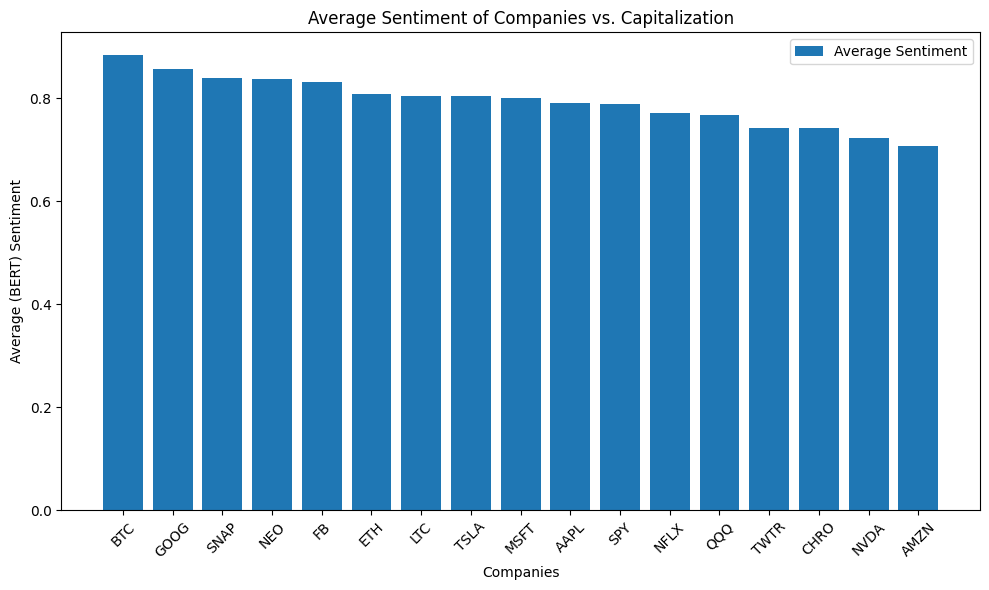

In [152]:
corr_df.set_index('Company', inplace=True)
df_sorted = corr_df.sort_values(by='Bert_Sentiment', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df_sorted.index, df_sorted['Bert_Sentiment'], label='Average Sentiment')
plt.xlabel('Companies')
plt.ylabel('Average (BERT) Sentiment')
plt.xticks(rotation=45) 
plt.title('Average Sentiment of Companies vs. Capitalization')
plt.legend()
plt.tight_layout() 
plt.show()

In [150]:
from scipy.stats import pearsonr, spearmanr

corrr_df = corr_df.drop([6,7])
pearson_corr, pearson_pvalue = pearsonr(corrr_df['Bert_Sentiment'], corrr_df['Capitalization'])
spearman_corr, spearman_pvalue = spearmanr(corrr_df['Bert_Sentiment'], corrr_df['Capitalization'])

# Print the correlation coefficients
print(f"Pearson Correlation Coefficient: {pearson_corr}, P-value: {pearson_pvalue}")
print(f"Spearman Rank Correlation Coefficient: {spearman_corr}, P-value: {spearman_pvalue}")

Pearson Correlation Coefficient: [0.19664869], P-value: [0.48239858]
Spearman Rank Correlation Coefficient: 0.05357142857142857, P-value: 0.8496099367776071


## Part 4:
Find examples where the classifiers do not agree on the sentiment of the tweet and analyze the results and discuss where does each classifier make mistakes. This part is mostly for the first 3 classifiers, because as we all know, when ChatGPT makes classification mistakes, it is really hard to solve!

In [154]:
df_bert

,Text,Predicted Sentiment
0,rt @unitedhealthgrp: $unh wichmann: unh genera...,1
1,nice shake out of weak hands yesterday mm's w...,1
2,rt @momostocktrades: $vdrm $cnbx $owcp $usrm $...,0
3,commercial metals company director just picked...,1
4,hunting for stocks to short? here's one w/ a l...,1
...,...,...
9995,$atrs - current report filing (8-k) https://t....,1
9996,$wdr looking for an entry for next leg up. lon...,1
9997,rt @goonalerts: i just came through again and ...,1
9998,#travelzoo $89* -- las vegas nonstop flights f...,1


In [155]:
df_logistic

,Text,Predicted Sentiment
0,rt @ unitedhealthgrp : $ unh wichmann : unh ge...,1
1,nice shake weak hand yesterday mm 's 're onto ...,1
2,rt @ momostocktrades : $ vdrm $ cnbx $ owcp $ ...,1
3,"commercial metal company director picked 1,692...",0
4,hunting stock short ? 's one w/ low piotroski ...,1
...,...,...
9995,$ atrs - current report filing ( 8-k ) http : ...,0
9996,$ wdr looking entry next leg . long 17.44 run ...,0
9997,rt @ goonalerts : came picked large order $ nx...,1
9998,# travelzoo $ 89 * -- la vega nonstop flight m...,0


In [167]:
non_common_predictions = [2, 3, 9998, 9999]

for ind in non_common_predictions:
    print(df_bert.iloc[ind]['Text'])
    print('Bert', df_bert.iloc[ind]['Predicted Sentiment'])
    print('Logistic', df_logistic.iloc[ind]['Predicted Sentiment'])
    print('-----------------------')

rt @momostocktrades: $vdrm $cnbx $owcp $usrm $aapl $fb $goog #stocks $znga $snap $srpt $amgn $icnb $nak $pmcb $svte $frzt $lqmt $chro $gs h…
Bert 0
Logistic 1
-----------------------
commercial metals company director just picked up 1,692 shares  https://t.co/40v0re1io2 $cmc
Bert 1
Logistic 0
-----------------------
#travelzoo $89* -- las vegas nonstop flights from minneapolis (o/w). read blog: https://t.co/gcxkk1zjvg $tzoo
Bert 1
Logistic 0
-----------------------
rt @philstockworld: tradetalks: will the trend ever change? $spy $qqq @jillmalandrino with phil davis, ceo @philstockworld -- https://t.co/…
Bert 1
Logistic 0
-----------------------


As we can see, some of these different predictions make sense, as the sentiment of the tweet is mostly neutral! However, since Fine-tuned BERT model had a better accuracy, we can stick to its results and prefer it to the predictions of the simple Logistic Regression.

Also, we need to note that BERT was only finetuned for 3 epochs and half of the data of the previous part; otherwise it could have a much better result!

# Discussion

Improving the performance of a sentiment analysis model, especially when dealing with specialized domains like finance, can be challenging. However, there are several strategies you can employ to enhance the effectiveness of your models. These include ensemble methods like stacking classifiers, further fine-tuning, and leveraging transfer learning. Let's discuss these approaches:

### 1. Stacking Classifiers
Stacking (or stacked generalization) involves training a new model to combine the predictions of several base models. The main idea is that the stacker model learns how to best combine the predictions from the base models. Here’s how you can proceed:

- **Base Models**: Use a diverse set of models as your base classifiers. This can include your fine-tuned BERT model, along with other machine learning models you have (like SVM, RandomForest, etc.).
- **Stacker Model**: The stacker model (often a simpler model like logistic regression) is trained on the predictions made by the base models. This helps in capturing the strengths of each base model.

### 2. Further Fine-Tuning
If the fine-tuned BERT model isn't performing as expected, consider the following adjustments:

- **Data Quality and Quantity**: More data, especially domain-specific data, can significantly help. Also, ensure the data quality is high and representative of the problem space.
- **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, and numbers of training epochs.
- **Class Imbalance**: If your dataset is imbalanced, consider techniques like oversampling, undersampling, or using class weights during training.

### 3. Transfer Learning and Fine-Tuning
Transfer learning involves taking a model trained on one task and fine-tuning it on a new, related task. Here's how to optimize its use:

- **Pretrained Models**: Start with a model pre-trained on a large corpus. For financial data, if available, use a model pre-trained on a similar domain.
- **Domain-Specific Fine-Tuning**: After initial fine-tuning, you can further fine-tune the model on a more specific subset of your data. For instance, focus on particular financial instruments or markets.
- **Sequential Transfer Learning**: Sometimes, it’s beneficial to fine-tune in stages. Start with a broad domain and gradually fine-tune on narrower domains.

### 4. Other Techniques to Consider
- **Data Augmentation**: Techniques like synonym replacement or back-translation can expand your dataset and introduce more variability.
- **Feature Engineering**: For non-BERT models, effective feature engineering (like TF-IDF, n-grams) can be crucial.
- **Ensemble Methods**: Beyond stacking, other ensemble techniques like bagging and boosting can be employed.
- **Regularization Techniques**: To avoid overfitting, especially in complex models like BERT, use regularization techniques.

### 5. Evaluation and Iteration
- **Metric Selection**: Ensure you are using the right metrics to evaluate your model’s performance (accuracy, F1-score, ROC-AUC, etc.).
- **Error Analysis**: Analyze where the model is making errors and adjust your approach based on these insights.

Remember, model improvement is often an iterative process. It may require several rounds of fine-tuning, experimenting with different models and techniques, and careful analysis of the results to understand where improvements can be made.

